In [363]:
#%reset -f
import pandas as pd
import numpy as np
import datetime as dt
import random
import time
import math
import itertools
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import scipy.integrate as integrate

almNum = 3
ocorr = 100
t_sample = 60
base_hour = dt.datetime(2018, 1,9,9,0,0)
occor_num = 0

#Settings alarms
a = np.zeros(1, dtype=int)
ocorr = 10
duration = 120 #120sec
hour_init = base_hour

b = np.zeros(1, dtype=int)
pAb =1
delay_b = 60 #seconds
duration_b = 120

c = np.zeros(1, dtype=int)
pAc = 0.6
delay_c = 15 #seconds
duration_c = 120


#Alarm Series Generation, A (cause), B(Effect). C(Effect)
while(occor_num < ocorr): 
    
    #A generation - begin
    srtd_hour = random.normalvariate(3, 1)
    srtd_hour_begin = hour_init + dt.timedelta(hours=srtd_hour)
    srtd_hour_end = srtd_hour_begin + dt.timedelta(seconds = duration)

    idx_init_a_occor = int(math.ceil((srtd_hour_begin - base_hour).total_seconds()/t_sample))
    idx_end_a_occor = int(math.ceil((srtd_hour_end - base_hour).total_seconds()/t_sample))
        
    if(idx_end_a_occor > a.size):
            a.resize(idx_end_a_occor)

    for i in np.arange(idx_init_a_occor, idx_end_a_occor + 1):
        a[i-1] = 1
    #A generation - end
         
    
    #B generation begin
    srtd_prob_b = random.uniform(0,1)  
    if srtd_prob_b <= pAb:
        srtd_hour_begin_b = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
        srtd_hour_end_b = srtd_hour_begin_b + dt.timedelta(seconds=duration_b)

        idx_init_b_occor = int(math.ceil((srtd_hour_begin_b - base_hour).total_seconds()/t_sample))
        idx_end_b_occor = int(math.ceil((srtd_hour_end_b - base_hour).total_seconds()/t_sample))

        if(idx_end_b_occor > b.size):
                b.resize(idx_end_b_occor)

        for j in np.arange(idx_init_b_occor, idx_end_b_occor +1):
            b[j-1] =  1  
    #B generation end

    #C generation begin
    srtd_prob_c = random.uniform(0,1)
    if srtd_prob_c <= pAc:
        srtd_hour_begin_c = srtd_hour_begin + dt.timedelta(hours = delay_b/3600)
        srtd_hour_end_c = srtd_hour_begin_c + dt.timedelta(seconds=duration_c)

        idx_init_c_occor = int(math.ceil((srtd_hour_begin_c - base_hour).total_seconds()/t_sample))
        idx_end_c_occor = int(math.ceil((srtd_hour_end_c - base_hour).total_seconds()/t_sample))
        
        if(idx_end_c_occor > c.size):
            c.resize(idx_end_c_occor)

        for j in np.arange(idx_init_c_occor, idx_end_c_occor +1):
            c[j-1] = 1    
    #C generation end
    
    hour_init = srtd_hour_begin
    occor_num = occor_num + 1

#Making series the same length
max_len = max(a, b, c, key=len).size
a = np.concatenate([a, np.zeros(max_len - a.size)])
b = np.concatenate([b, np.zeros(max_len - b.size)])
c = np.concatenate([c, np.zeros(max_len - c.size)])
sum(a)

30.0

In [316]:
a

array([0., 0., 0., ..., 1., 1., 0.])

In [11]:
#Significance test
def significance_test(a,b,k,l,h,sup_lim, n):
    '''
        significance_test(a,b,k,l,h,sup_lim, n)
    '''
    transferEntropies = []
    
    np.random.seed(int(time.time()))
    for i in np.arange(0,n):
        np.random.shuffle(a)
        transferEntropies.append(te(k,l,h,a[:],b))
    kde = sm.nonparametric.KDEUnivariate(transferEntropies)
    kde.fit()
    
    lvl_sig = kde.icdf[get_lim_index(kde.cdf, sup_lim)]
    return lvl_sig

In [12]:
def get_lim_index(cdf, lim):
    summation = 0
    index = 0
    for i in np.arange(0, cdf.size):
        if(summation < lim):
            summation += cdf[i]
        else:
            index = i-1
            break
    return index
    

In [288]:
def joint_probability(k,l, h, a, b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''

    #Alarm Series A (cause), B (effect), same len
    #tested
    sizeSeries = a.size
    transEntropy = 0
    numStates = 2**(k + l  + 1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    counting = np.zeros(numStates)
    prob_cnjt = np.zeros(numStates)
    a_prob_ind = []
    b_prob_ind = []
    
    start = time.clock()
    #joitn probability p(i_sub_t+1), i_sub_t**k, j_sub_t**l)
    inicio = np.max([k,l]) - 1
    for i in np.arange(inicio, sizeSeries - h):
        for hk in np.arange(0,k):
                b_prob_ind.append(b[i - hk])
        for hl in np.arange(0,l):
                a_prob_ind.append(a[i - hl])

        ab = [b[i + h]] + b_prob_ind + a_prob_ind 
        index_comb = combinations.index(ab)
        counting[index_comb] = counting[index_comb] + 1

        a_prob_ind = []
        b_prob_ind = []

    total = sum(counting)
    for i, cnt in enumerate(counting):
        if total != 0:
            prob_cnjt[i] = cnt/total
     
    end = time.clock()
    print(end-start)
    return prob_cnjt

In [426]:
##for paper test
def joint_probability_new(k,l,h, a, b, lbl_a, lbl_b):
    '''
        k B time horizon
        l A time horizon
        h instant in the future of serie B
        
        a, b array type'''
    
    numStates=2**(k+l+1)
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    prob_cnjt = np.zeros(numStates)
    
    #Alarm Series A (cause), B (effect), same len
    #teste
    start = time.clock()
    b_shftd = b.tolist()[2:]
    a = a.tolist()[:-1]
    b = b.tolist()[:-1]
    
    print(len(a))
    matrix = np.matrix([b_shftd,b,a])
    print(matrix.shape)
    
    df = pd.DataFrame(matrix, columns = ['b_ftr', lbl_b, lbl_a])
    df = df.drop(df.index[0])
    gpd = df.groupby(['b_ftr', lbl_b, lbl_a], as_index=False).size().reset_index(name='Count')
    total = sum(gpd['Count'])
    
    for i in np.arange(0,gpd.shape[0]):
        comb = [e for e in gpd.iloc[i][0:3].values.tolist()]
        idx = combinations.index(comb)
        prob_cnjt[idx] = gpd.iloc[i]['Count']/total
    
    end = time.clock()
    print(end-start)
    return prob_cnjt

In [427]:
b = b.astype(int)
a = a.astype(int)

te(1,1,1,a,b,'a', 'b')

2042
(1, 3)
0.0161660000000019


0.0

In [425]:
x = [1,2,3]
y = [3,4,5]
np.matrix(x,y)

TypeError: data type not understood

In [362]:
b = b.astype(int)
a = a.astype(int)

te(1,1,1,a,b,'a', 'b')

[[1]] [[2]]
[[array([[3],
       [4]]) array([[2]]) array([[1]])]]
0.019624000000000308


0.0

In [305]:
x  =[1,2,3]
x

[2, 3]

In [76]:

m = np.matrix([pd.Series([1,2,3]),[1,2,3]])
m.T

matrix([[1, 1],
        [2, 2],
        [3, 3]])

In [14]:
#Joint probability evaluation p(i_t+h, i_t**k)
#tested
def joint_prob_ih_ik(k,l, joint_prob_ih_ik_jl):
    states_ith_ik = list(map(list, itertools.product([0, 1], repeat=k + 1)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1))) 
    p_jnt_ith_ik = np.zeros(2**(k+1))
    
    for i, state in enumerate(states_ith_ik):
        for j, comb in enumerate(combinations):
            if comb[0:k+1] == state:
                p_jnt_ith_ik[i] = p_jnt_ith_ik[i] + joint_prob_ih_ik_jl[j]
    return p_jnt_ith_ik

In [15]:
def conditional_prob(k,l,joint_prob):
    states = list(map(list, itertools.product([0, 1], repeat=k+l)))
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))

    size = int(joint_prob.size/2)
    conditional = np.zeros(2**(k+l+1))

    for i,state in enumerate(states):
        index_zero = combinations.index([0] + state)
        prob_zero = joint_prob[index_zero]

        index_one = combinations.index([1] + state)
        prob_one = joint_prob[index_one]

        if(prob_zero + prob_one != 0):
            conditional[i] = prob_zero/(prob_zero+ prob_one)
            conditional[i + 2**(k+l)] = prob_one/(prob_zero+ prob_one)
    return conditional

In [16]:
#Division of the conditionals in log2 
#tested
def conditional_div(k,l,conditional_num, conditional_den):
    combinations = list(map(list, itertools.product([0, 1], repeat=k+l+1)))
    conditional_division = np.zeros(conditional_num.size)
    states_den = list(map(list, itertools.product([0, 1], repeat=1+k)))
    for j, comb in enumerate(combinations):
        if(conditional_den[states_den.index(comb[0:k+1])] != 0):
            conditional_division[j] = conditional_num[j]/conditional_den[states_den.index(comb[0:k+1])]            
    return conditional_division

In [292]:
#Transfer entropy final evaluation
def te(k,l,h,a,b, lbl_a, lbl_b):
    '''
        transentropy a->b
        te(k,l,h,a,b)
        k - dimension of b
        l - dimension of aDataFrame count duplicate rows and ...
        h -> instant in the future of a
    '''
    joint_p_ih_ik_jl = joint_probability_new(k,l,h,a,b, lbl_a, lbl_b)
    #joint_p_ih_ik_jl = joint_probability(k,l,h,a,b)
    
    joint_p_ih_ik = joint_prob_ih_ik(k,l, joint_p_ih_ik_jl)
    conditional_num = conditional_prob(k,l,joint_p_ih_ik_jl)
    conditional_den = conditional_prob(k,0, joint_p_ih_ik)    
    
    div = conditional_div(k,l,conditional_num, conditional_den)
    
    #log2 from the division of the conditionals ->
    #p(i_sub_t+h|i_sub_t**k, j_sub_t**l) /p(i_sub_t+h|i_t**k)
    
    log2_div_cond = np.log2(div[div!=0])
    te = np.sum(joint_p_ih_ik_jl[div!=0]*log2_div_cond)
    
    return te

In [187]:
combinations = list(map(list, itertools.product([0, 1], repeat=3)))
c

In [19]:
#Variavéis analizadas 1,2,3,6,7,8,9,21,46

dist6 = pd.read_csv('dist6.csv', names=['xmeas%02d_low' % x for x in range(1, 74)] + ['xmeas%02d_high' % x for x in range(1, 74)])
dist6_sel_vars = dist6[['xmeas01_low', 'xmeas02_low', 'xmeas03_low', 'xmeas06_low', 
        'xmeas07_low', 'xmeas08_low', 'xmeas09_low', 'xmeas21_low', 'xmeas46_low',
        'xmeas01_high', 'xmeas02_high', 'xmeas03_high', 'xmeas06_high', 
        'xmeas07_high', 'xmeas08_high', 'xmeas09_high', 'xmeas21_high', 'xmeas46_high']].copy()


In [20]:
sig_matrix = np.zeros([dist6_sel_vars.columns.size,dist6_sel_vars.columns.size])
for i in np.arange(0, dist6_sel_vars.columns.size):
    for j in np.arange(0, dist6_sel_vars.columns.size):
        if(j != i + dist6_sel_vars.columns.size/2):
            sig_matrix[i][j] = significance_test(dist6_sel_vars[dist6_sel_vars.columns[i]],
                                dist6_sel_vars[dist6_sel_vars.columns[j]],1,1,1,0.95, 10)
        else:
            sig_matrix[i][j] = 0

/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/home/rute/.conda/envs/pesquisa/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in mu

In [ ]:
sig_matrix


In [13]:
te(1,1,1, dist6_sel_vars['xmeas01_low'],  dist6_sel_vars['xmeas02_low'])

2.979227644918194e-05

In [25]:
transEntropy = np.zeros([dist6_sel_vars.columns.size,dist6_sel_vars.columns.size])
for i in np.arange(0, dist6_sel_vars.columns.size):
    for j in np.arange(0, dist6_sel_vars.columns.size):
        if(j != i + dist6_sel_vars.columns.size/2):
            transEntropy[i][j] = te(1,1,1,dist6_sel_vars[dist6_sel_vars.columns[i]],
                                     dist6_sel_vars[dist6_sel_vars.columns[j]])
        else:
            transEntropy[i][j] = 0

In [30]:
te_df = pd.DataFrame(transEntropy, columns = ['xmeas01_low', 'xmeas02_low', 'xmeas03_low', 'xmeas06_low', 
        'xmeas07_low', 'xmeas08_low', 'xmeas09_low', 'xmeas21_low', 'xmeas46_low',
        'xmeas01_high', 'xmeas02_high', 'xmeas03_high', 'xmeas06_high', 
        'xmeas07_high', 'xmeas08_high', 'xmeas09_high', 'xmeas21_high', 'xmeas46_high'])

In [33]:
#te_df.to_csv("TransferEntropy.csv")

0.08672869259416369

In [39]:
import seaborn as sns
def plot_mat_corrs(figsize, annot, matrix):
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)
    sns.heatmap(matrix, cmap=cmap, center=0, annot=annot, vmax=max(matrix.max()))
    plt.show()

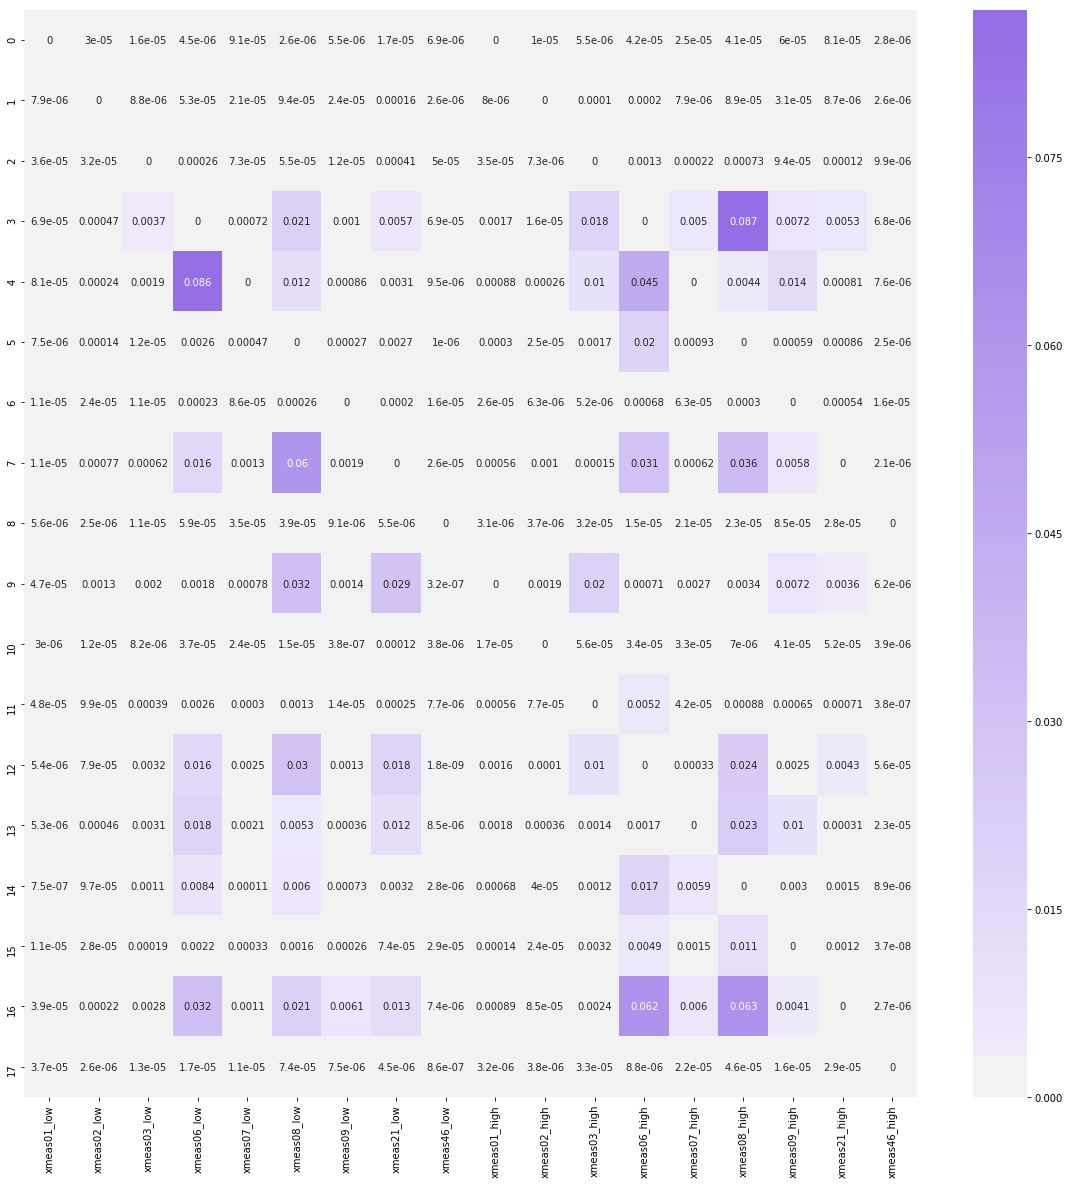

In [40]:
plot_mat_corrs(figsize=(20,20), annot=True, matrix = te_df)

In [ ]:
#joint probablity for functions test
#joint_p_ih_ik_jl = np.array([0.97322404,0.00546448,0.00491803,0,0,0.00546448, 0.00546448, 0.00546448])

#aproximate results for this test

#p(ith, ik)
#jnt_p_ih_ik = [0.97868852,0.00491803,0.00546448,0.0109286] 

#p(i_t+h|i**k, j**l)
#cond_p_ih_ik_jl =  [1,0.5,0.4736841094123,0,0,0.5, 0.52631589085076,1]

#p(i_th|i_k)
#cond_p_ih_ik = [0.994711793480152,0.31035179088550,0.0552469991962,0.68964820911449]